#### Imports and fetching data 

In [27]:
import pandas as pd
from companies import companies
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pandas_datareader import data as pdr
import yfinance as yf
import time

holdings = pd.read_excel("BUFC_May_2025_Allocations.xlsx", sheet_name=0) 
holdings = holdings[:-2]
holdings = holdings.drop(holdings.iloc[1].name)
holdings = holdings.drop(holdings.iloc[14].name)
holdings.loc[holdings.index[0], 'Current Price'] = 1.0
holdings.loc[holdings.index[0], 'Current Value'] = holdings.loc[holdings.index[0], 'Total Cost Basis']
holdings.loc[holdings.index[0], 'Average Cost Basis'] = 1.0
holdings = holdings.rename(columns={"Unnamed: 0": "Company"})
holdings["Ticker"] = holdings["Company"].str.extract(r":([A-Z]+)\)")
holdings = holdings.reset_index()
holdings = holdings.drop('index', axis=1)

sector_allocations = pd.read_excel("BUFC_May_2025_Allocations.xlsx", sheet_name=1) 
sector_allocations.loc[sector_allocations.index[-1], '% of Fund'] = 1.0

In [ ]:
from polygon import RESTClient
from datetime import datetime
from dateutil.relativedelta import relativedelta

client = RESTClient("FnlGiHgIUqRipoOra1mzJQpYJTrMUqTS") # don't share this pls 

end_date = datetime.today()
start_date = pd.to_datetime("2025-01-01")
start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")

prices_data = pd.DataFrame()

for stock in companies:
    try:
        aggs = client.get_aggs(
            ticker=stock,
            multiplier=1,
            timespan="day",
            from_=start_str,
            to=end_str,
            adjusted=True,
            sort="asc",
            limit=120
        )
        temp_df = pd.DataFrame([{
            "date": datetime.utcfromtimestamp(a.timestamp / 1000).date(),
            stock: a.close
        } for a in aggs])

        temp_df.set_index("date", inplace=True)
        prices_data = prices_data.join(temp_df, how="outer") if not prices_data.empty else temp_df
    except Exception as e:
        print(f"Failed to fetch {stock}: {e}")
    time.sleep(15)

In [31]:
#define new portfolio df 
columns = ['Ticker', 'shares', 'cost basis', 'current value', 'return', 'weights']
live_portfolio = pd.DataFrame(columns=columns)

latest_prices = prices_data.ffill().iloc[-1]

cash_row = holdings.iloc[0]
cash_amount = cash_row["Total Cost Basis"]

live_portfolio.loc[len(live_portfolio)] = [
    "SPAXX",           
    cash_amount,    
    cash_amount,            
    cash_amount,       
    0,                 
    0                   
]

for _, row in holdings.iloc[1:].iterrows(): 
    ticker = row["Ticker"]
    
    shares = row["Total Cost Basis"] / row["Average Cost Basis"]
    cost_basis = row["Total Cost Basis"]
    current_price = latest_prices[ticker]
    current_value = shares * current_price
    ret = (current_value - cost_basis) / cost_basis
    
    live_portfolio.loc[len(live_portfolio)] = [
        ticker, shares, cost_basis, current_value, ret, 0
    ]

portfolio_value = live_portfolio["current value"].sum()
live_portfolio["weights"] = live_portfolio["current value"] / portfolio_value

live_portfolio = live_portfolio.sort_values("weights", ascending=False).reset_index(drop=True)

#### Live portfolio analysis 

In [32]:
live_portfolio

,Ticker,shares,cost basis,current value,return,weights
0,PSCT,2865.00,136144.80,121848.4500,-0.105008,0.106081
1,PSCI,933.00,86489.10,117906.1023,0.363248,0.102648
2,STEP,1495.00,44431.40,86485.7500,0.946501,0.075294
3,KBWR,1226.00,70776.98,68043.0000,-0.038628,0.059238
4,PSCH,1680.00,69720.00,67401.6000,-0.033253,0.058679
5,SPAXX,66121.67,66121.67,66121.6700,0.000000,0.057565
6,PSR,616.00,54904.08,56774.9952,0.034076,0.049428
7,RSPF,744.00,37051.20,54473.0760,0.470211,0.047424
8,EHC,425.00,41824.25,51382.5000,0.228534,0.044733
9,ENSG,325.00,16776.50,47859.5000,1.852770,0.041666


In [33]:
print(f"Total portfolio value as of {end_date}: ${portfolio_value:,.2f}")

Total portfolio value as of 2025-06-03: $1,148,639.75


In [34]:
start_date = "2025-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

client = RESTClient("FnlGiHgIUqRipoOra1mzJQpYJTrMUqTS")

aggs = client.get_aggs(
    ticker="IWM",
    multiplier=1,
    timespan="day",
    from_=start_date,
    to=end_date,
    adjusted=True,
    sort="asc",
    limit=5000
)

rut_df = pd.DataFrame([{
    "date": pd.to_datetime(a.timestamp, unit="ms"),
    "IWM": a.close
} for a in aggs])

rut_df['date'] = pd.to_datetime(rut_df['date'])
rut_df.set_index('date', inplace=True)
rut_df.rename(columns={'IWM': 'price'}, inplace=True)
rut_series = rut_df['price']

In [36]:
tickers = list(prices_data.columns)  # use all tickers, including index ETFs

prices_data.index = pd.to_datetime(prices_data.index).normalize()
rut_series.index = pd.to_datetime(rut_series.index).normalize()

portfolio_returns = prices_data.pct_change().mean(axis=1)
benchmark_returns = rut_series.pct_change()
excess_returns = portfolio_returns - benchmark_returns

portfolio_cum = (1 + portfolio_returns.fillna(0)).cumprod()
benchmark_cum = (1 + benchmark_returns.fillna(0)).cumprod()
alpha_line = portfolio_cum - benchmark_cum

rolling_alpha = excess_returns.rolling(30).mean()

sectors = {'PSCI':'Index', 'PSCT':'Index', 'PSCM':'Index', 'PSCU':'Index',
        'RSPG':'Index', 'RSPF':'Index', 'MITK':'Tech','NXT':'Tech', 'PATK':
        'Industrials', 'PECO':'Real Estate', 'PUBM':'Tech', 'STEP':'Financial',
        'ENSG':'Healthcare', 'MODG':'Consumer','WINA':'Consumer', 'AGCO':'Industrials',
        'BMI':'Industrials', 'SKY':'Consumer', 'CVLT':'Tech', 'EHC':'Healthcare',
        'INMD':'Healthcare', 'PSR':'Index', 'KBWR':'Index', 'PSCC':'Index', 'PSCH':'Index'}

sector_map = {ticker: sectors[ticker] for ticker in tickers}
sector_excess = prices_data[tickers].pct_change().sub(benchmark_returns, axis=0)
sector_contributions = sector_excess.mean().groupby(sector_map).sum()

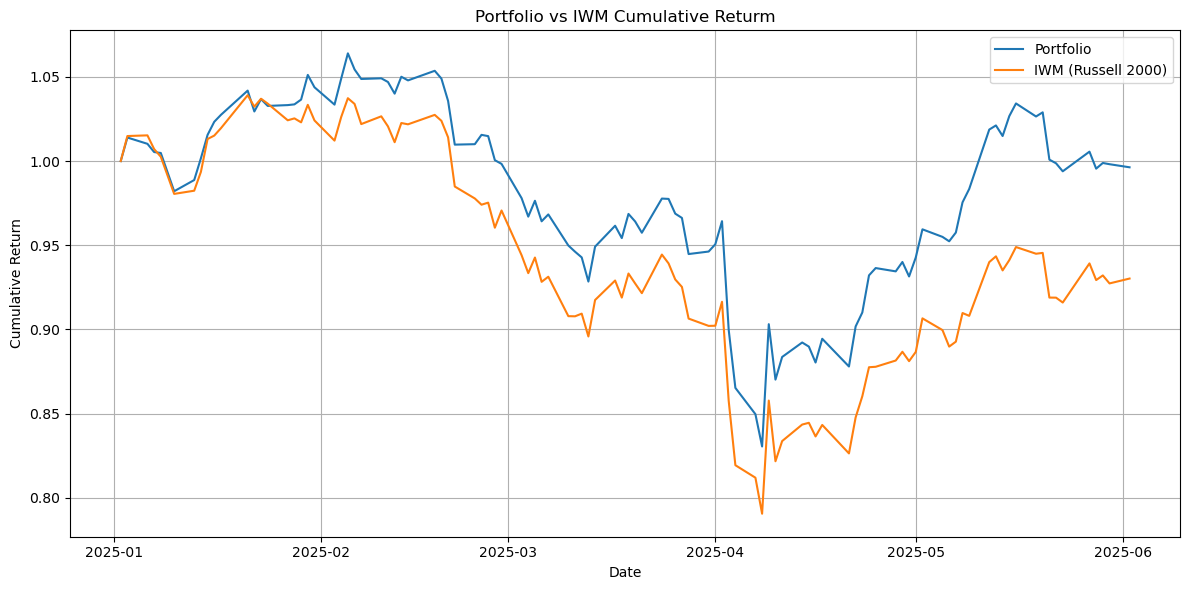

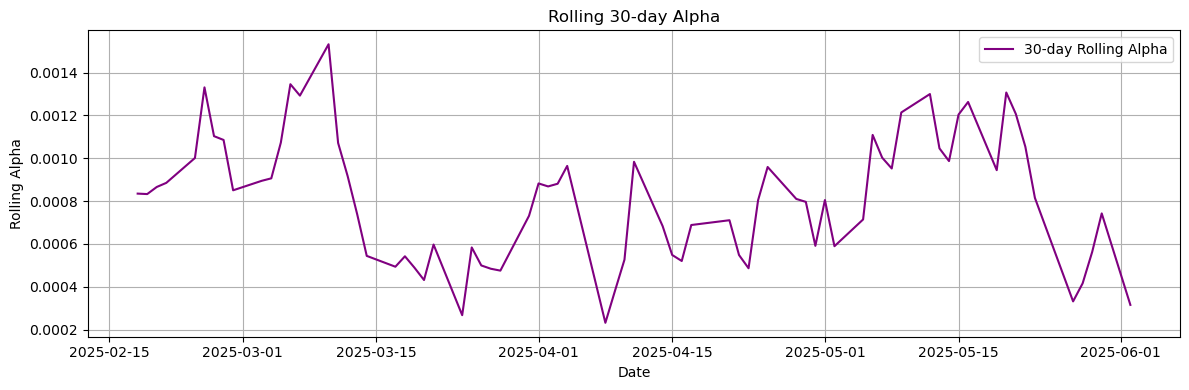

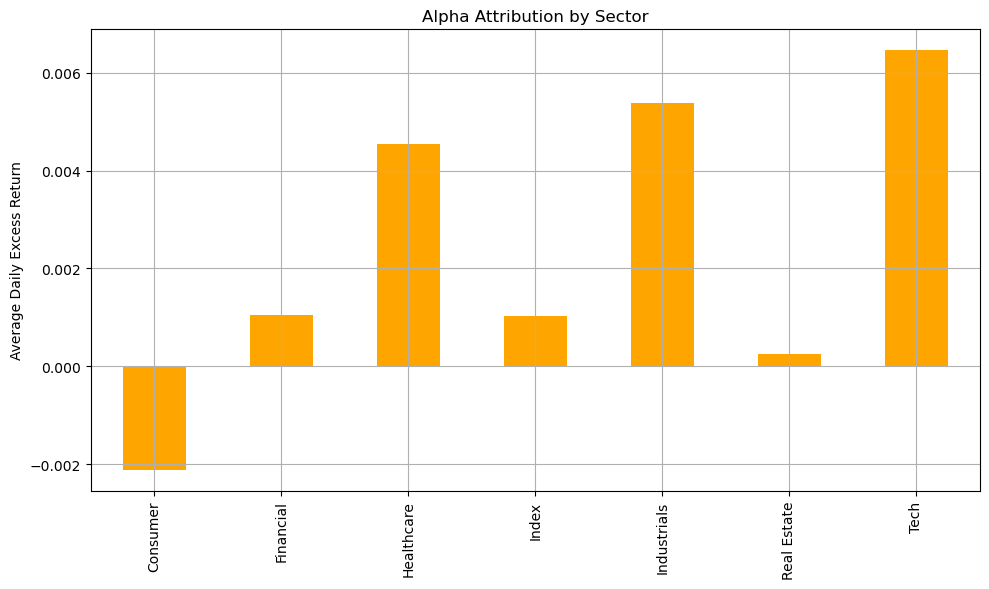

In [19]:
# Portfolio vs Benchmark with Alpha
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum, label='Portfolio')
plt.plot(benchmark_cum, label='IWM (Russell 2000)')
plt.title('Portfolio vs IWM Cumulative Returm')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rolling Alpha Plot
plt.figure(figsize=(12, 4))
plt.plot(rolling_alpha, label='30-day Rolling Alpha', color='purple')
plt.title('Rolling 30-day Alpha')
plt.xlabel('Date')
plt.ylabel('Rolling Alpha')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Alpha Attribution Bar Chart
plt.figure(figsize=(10, 6))
sector_contributions.plot(kind='bar', color='orange')
plt.title('Alpha Attribution by Sector')
plt.ylabel('Average Daily Excess Return')
plt.grid(True)
plt.tight_layout()
plt.show()

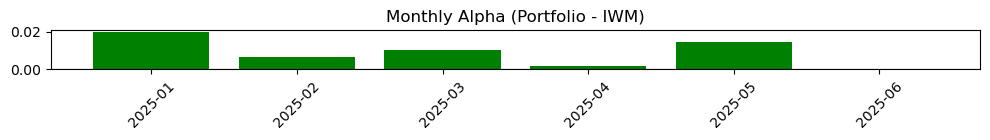

In [37]:
monthly_alpha = alpha_line.resample('M').last() - alpha_line.resample('M').first()
monthly_alpha.index = monthly_alpha.index.strftime('%Y-%m')

# Convert to DataFrame for heatmap-like display
alpha_df = pd.DataFrame(monthly_alpha, columns=['Alpha'])

plt.figure(figsize=(10, 1.5))
colors = alpha_df['Alpha'].apply(lambda x: 'green' if x > 0 else 'red')
plt.bar(alpha_df.index, alpha_df['Alpha'], color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45)
plt.title('Monthly Alpha (Portfolio - IWM)')
plt.tight_layout()
plt.show()

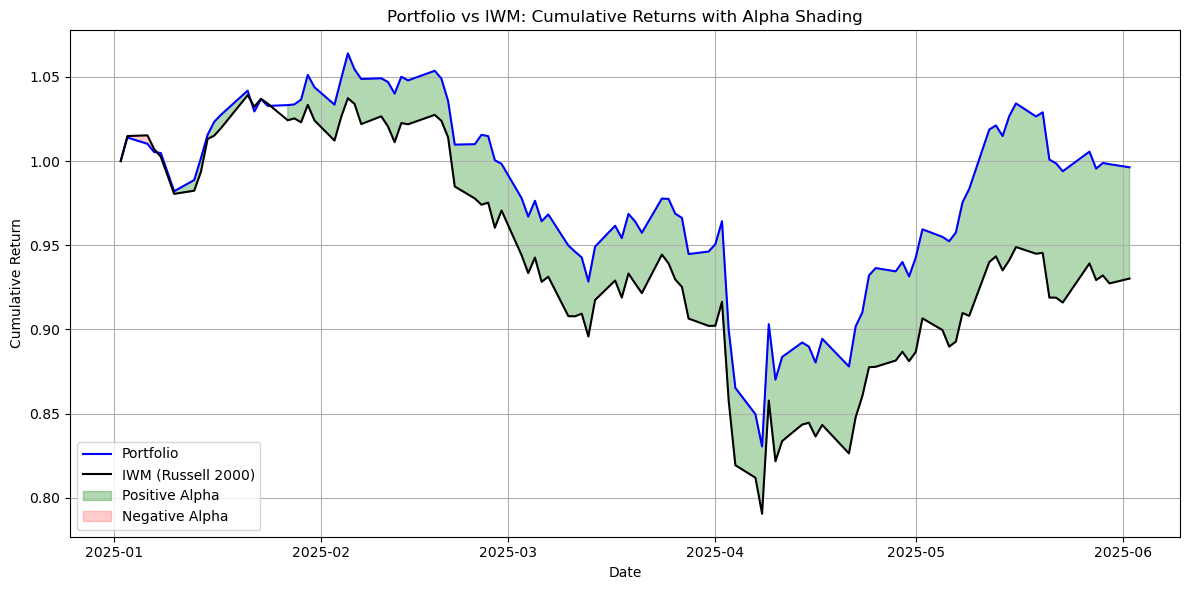

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum, label='Portfolio', color='blue')
plt.plot(benchmark_cum, label='IWM (Russell 2000)', color='black')

# Fill the area between the portfolio and benchmark
plt.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum > benchmark_cum),
                 color='green', alpha=0.3, label='Positive Alpha')
plt.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum <= benchmark_cum),
                 color='red', alpha=0.2, label='Negative Alpha')

plt.title('Portfolio vs IWM: Cumulative Returns with Alpha Shading')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


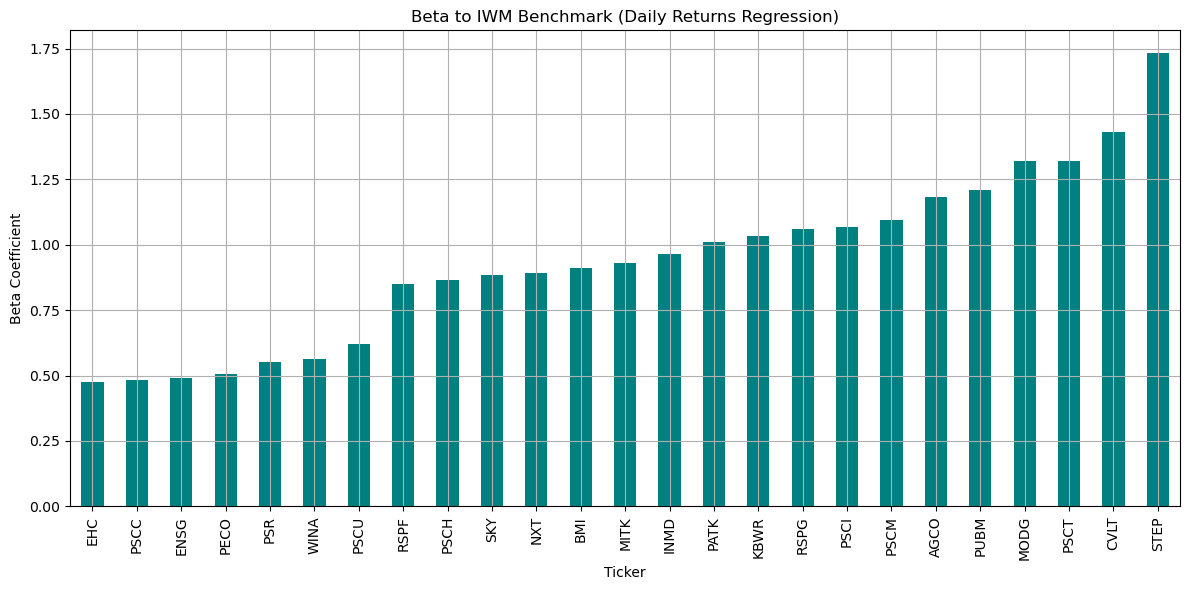

In [39]:
import statsmodels.api as sm

returns = prices_data.pct_change()
benchmark_returns = rut_series.pct_change()

returns = returns.loc[benchmark_returns.index]
benchmark_returns = benchmark_returns.loc[returns.index]

index_tickers = {'PSCI', 'PSCT', 'PSCM', 'PSCU', 'RSPG', 'RSPF', 'PSR', 'KBWR', 'PSCC', 'PSCH'}
bar_colors = 'teal'

betas = {}

for ticker in returns.columns:
    X = sm.add_constant(benchmark_returns)  # adds alpha
    y = returns[ticker]
    model = sm.OLS(y, X, missing='drop').fit()
    betas[ticker] = model.params[1]

beta_df = pd.Series(betas).sort_values()

plt.figure(figsize=(12, 6))
beta_df.plot(kind='bar', color=bar_colors)
plt.title('Beta to IWM Benchmark (Daily Returns Regression)')
plt.ylabel('Beta Coefficient')
plt.xlabel('Ticker')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Other ideas: 

Add metrics for Factor risk exposure, overall portfolio risk, optimal position sizing 
Indifference to index weightings → only investment attractiveness should matter  


## Portfolio Enhancements

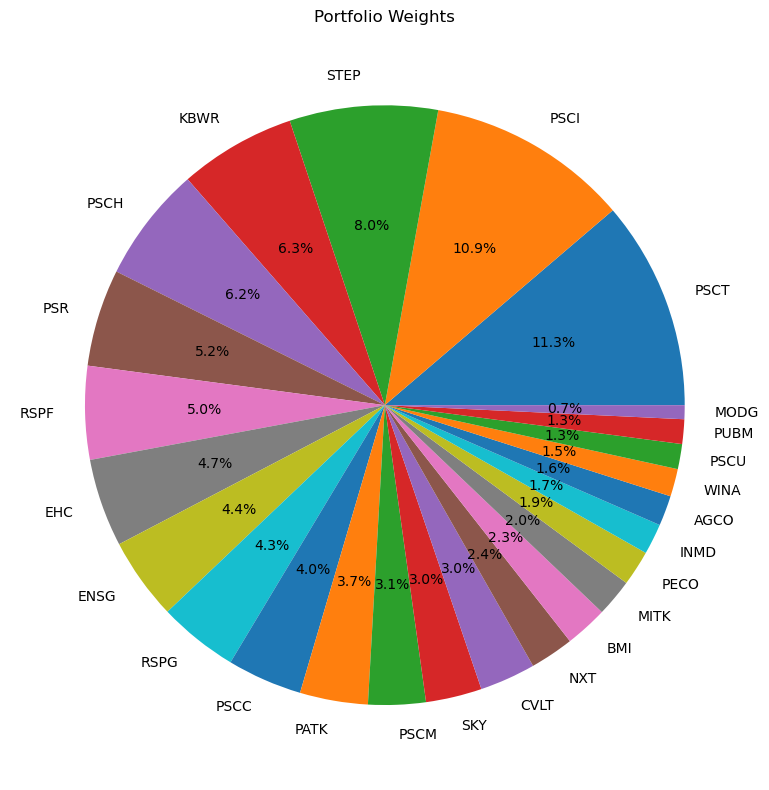

In [ ]:
#DON'T INCLUDE THIS I WAS JUST MESSING AROUND
import matplotlib.pyplot as plt
live_portfolio_no_cash = live_portfolio[live_portfolio["Ticker"] != "SPAXX"]
live_portfolio_no_cash.set_index("Ticker")["weights"].plot(
    kind="pie", autopct='%1.1f%%', figsize=(8, 8), title="Portfolio Weights"
)
plt.ylabel("")
plt.tight_layout()
plt.show()


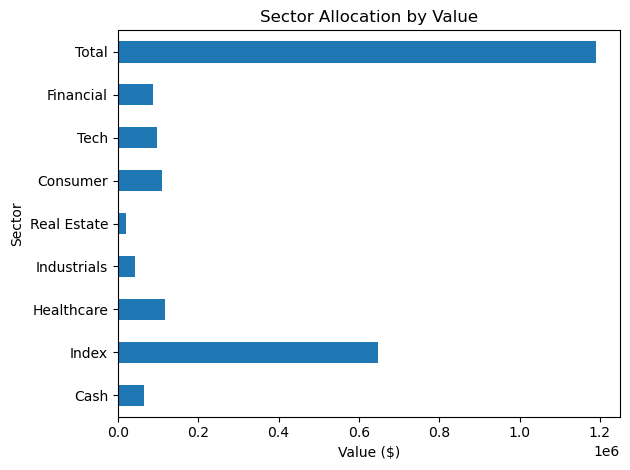

In [41]:
sector_allocations.plot(kind='barh', x='Sector', y='Value', legend=False, title="Sector Allocation by Value")
plt.xlabel("Value ($)")
plt.tight_layout()
plt.show()


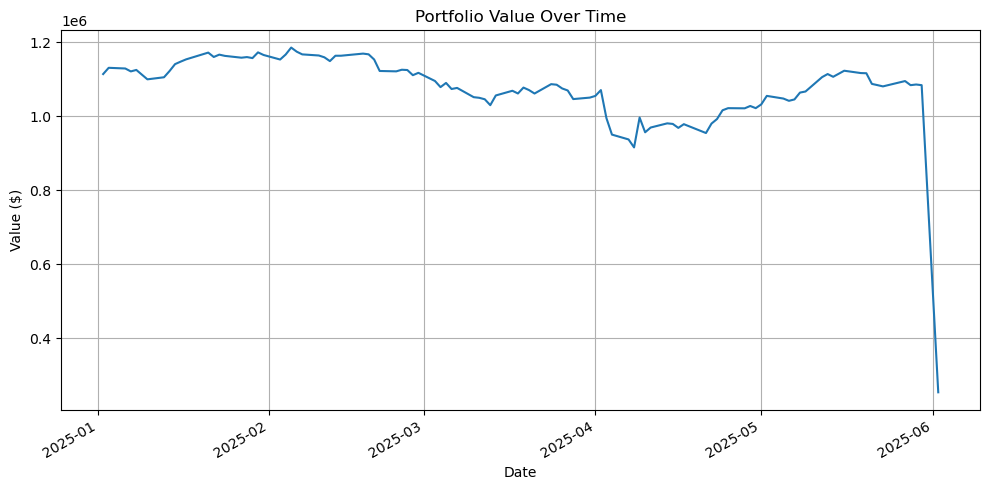

In [42]:
portfolio_value_series = (prices_data * live_portfolio.set_index("Ticker")["shares"]).sum(axis=1)
portfolio_value_series.plot(title="Portfolio Value Over Time", figsize=(10, 5))
plt.ylabel("Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/henryidone/anaconda3/lib/python3.11/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/8x/36t23nbx6g96nrf783_cfm100000gn/T/ipykernel_21275/3801044103.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


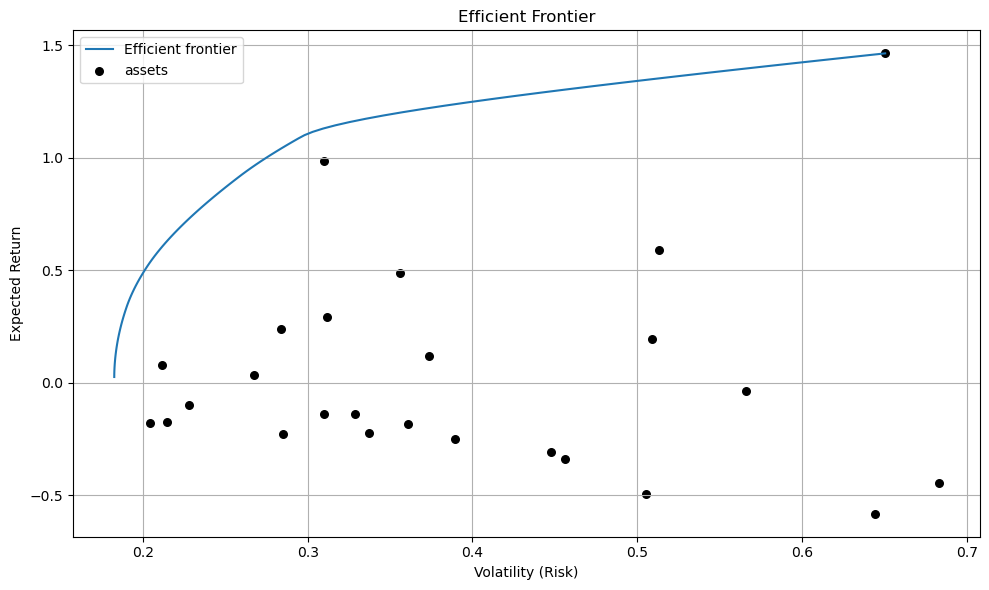

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.plotting import plot_efficient_frontier
import matplotlib.pyplot as plt

mu = expected_returns.mean_historical_return(prices_data)
S = risk_models.sample_cov(prices_data)

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(10, 6))
plot_efficient_frontier(ef, ax=ax, show_assets=True)

plt.title("Efficient Frontier")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:

# Beta Calculation with RSPG as Benchmark
from sklearn.linear_model import LinearRegression

benchmark_ticker = "RSPG"
returns = prices_data.pct_change().dropna()
benchmark_returns = returns[benchmark_ticker]

beta_results = {}
for ticker in returns.columns:
    if ticker == benchmark_ticker:
        continue
    combined = pd.concat([returns[ticker], benchmark_returns], axis=1).dropna()
    reg = LinearRegression().fit(combined[[benchmark_ticker]], combined[ticker])
    beta_results[ticker] = reg.coef_[0]

beta_df = pd.DataFrame.from_dict(beta_results, orient='index', columns=['Beta'])
beta_df.sort_values(by='Beta', ascending=False)


,Beta
STEP,1.082212
CVLT,0.901943
AGCO,0.865918
PSCT,0.854995
PUBM,0.753152
PSCM,0.748938
NXT,0.696362
KBWR,0.690821
PSCI,0.680278
PATK,0.656450


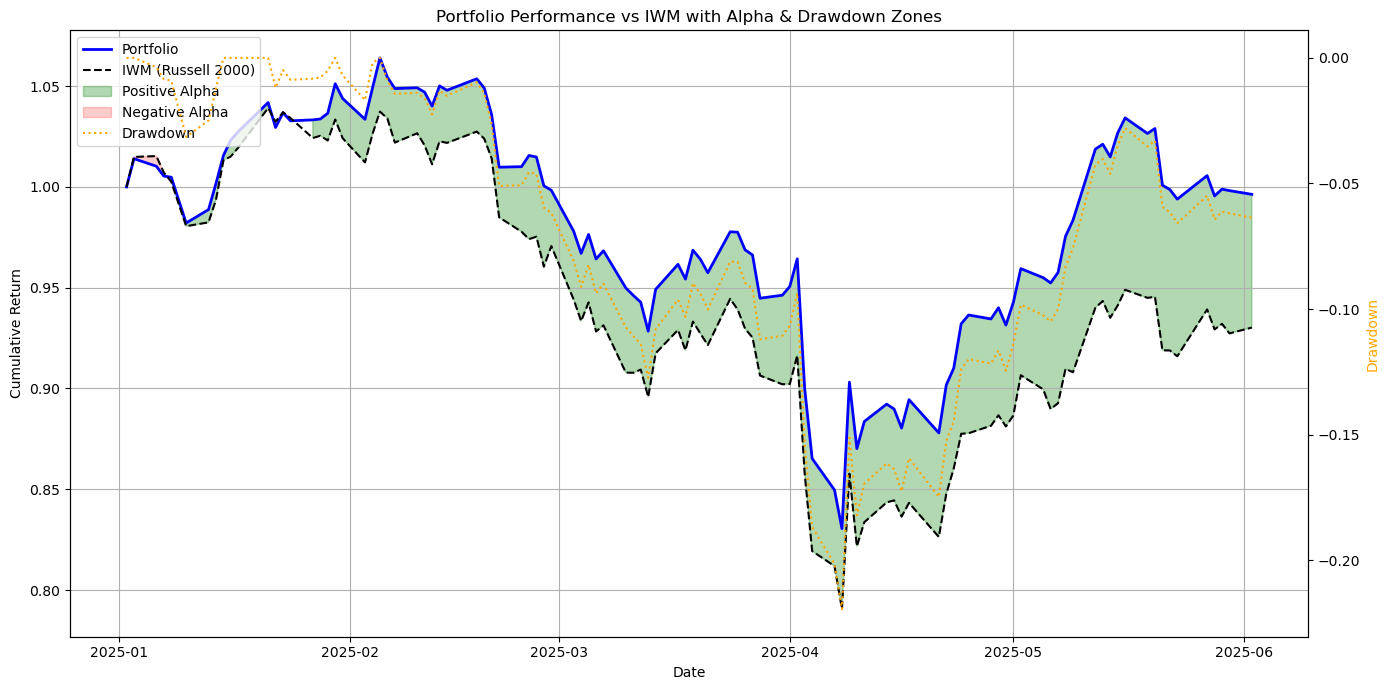

In [55]:
import matplotlib.pyplot as plt

portfolio_returns = prices_data.pct_change().mean(axis=1)
portfolio_cum = (1 + portfolio_returns.fillna(0)).cumprod()

benchmark_returns = rut_series.pct_change()
benchmark_cum = (1 + benchmark_returns.fillna(0)).cumprod()

portfolio_cum = portfolio_cum.loc[benchmark_cum.index]

rolling_max = portfolio_cum.cummax()
drawdown = (portfolio_cum - rolling_max) / rolling_max

alpha_diff = portfolio_cum - benchmark_cum

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(portfolio_cum, label='Portfolio', color='blue', linewidth=2)
ax1.plot(benchmark_cum, label='IWM (Russell 2000)', color='black', linestyle='--')

ax1.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum > benchmark_cum),
                 color='green', alpha=0.3, label='Positive Alpha')

ax1.fill_between(portfolio_cum.index, portfolio_cum, benchmark_cum,
                 where=(portfolio_cum <= benchmark_cum),
                 color='red', alpha=0.2, label='Negative Alpha')

ax2 = ax1.twinx()
ax2.plot(drawdown, color='orange', linestyle=':', linewidth=1.5, label='Drawdown')
ax2.set_ylabel('Drawdown', color='orange')

ax1.set_title('Portfolio Performance vs IWM with Alpha & Drawdown Zones')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True)
fig.tight_layout()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig("optimal_position_sizing.png", dpi=300)
plt.show()


In [52]:
weights = live_portfolio.set_index("Ticker")["weights"]
weights = weights.reindex(daily_returns.columns).fillna(0)

portfolio_returns = daily_returns.dot(weights)


volatility = portfolio_returns.std() * np.sqrt(252)
print(f"Annualized Volatility: {volatility:.2%}")

cumulative = (1 + portfolio_returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_dd = drawdown.min()
print(f"Max Drawdown: {max_dd:.2%}")

VaR_95 = np.percentile(portfolio_returns.dropna(), 5)
print(f"Value at Risk (95% daily): {VaR_95:.2%}")


Annualized Volatility: 26.66%
Max Drawdown: -21.06%
Value at Risk (95% daily): -2.32%


,Sharpe-Based,Volatility-Parity,Kelly-Based,Optimal (Combined)
EHC,1.5120,0.0445,2.7588,1.4392
BMI,0.8243,0.0387,1.3071,0.7244
NXT,1.0808,0.0212,0.9387,0.6842
ENSG,0.6257,0.0442,1.1337,0.6014
WINA,0.5695,0.0486,1.1338,0.5838
CVLT,0.7395,0.0269,0.8139,0.5289
PSR,0.2899,0.0649,0.7711,0.3745
AGCO,0.3802,0.0271,0.4223,0.2776
PATK,0.3070,0.0369,0.4640,0.2697
RSPF,0.1647,0.0516,0.3484,0.1880


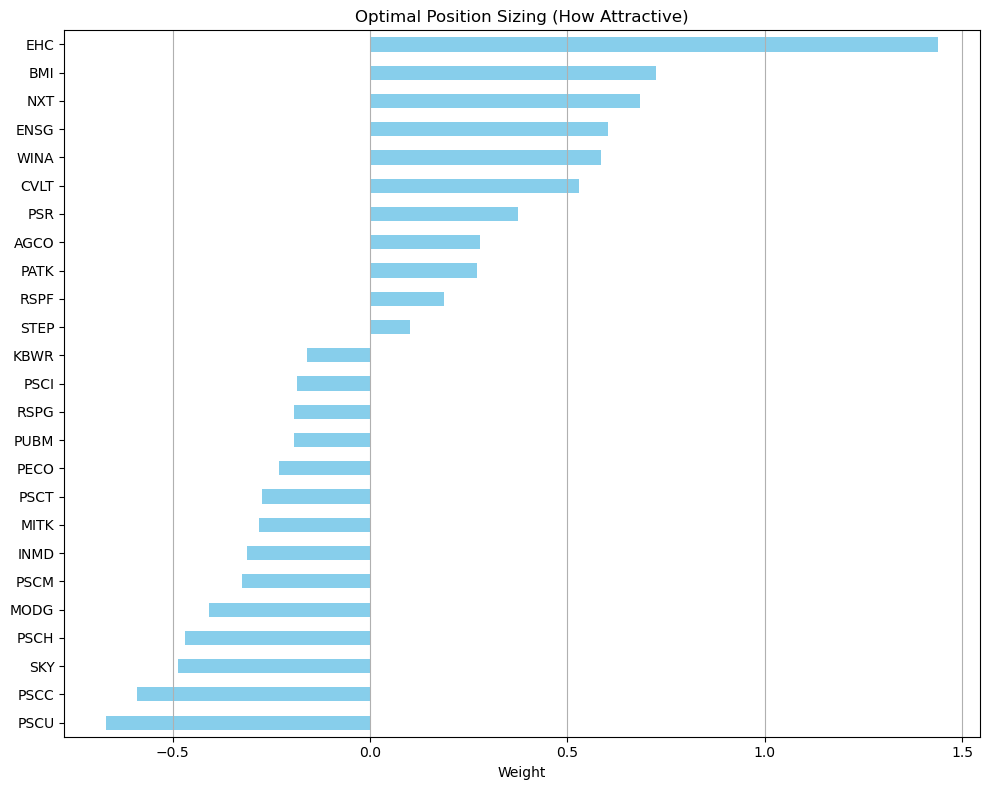

In [56]:
returns = prices_data.pct_change().dropna()

mean_daily = returns.mean()
volatility_daily = returns.std()
sharpe_like = mean_daily / volatility_daily  

sharpe_weights = sharpe_like / sharpe_like.sum()
vol_weights = (1 / volatility_daily) / (1 / volatility_daily).sum()

kelly_like = mean_daily / (returns.var())
kelly_weights = kelly_like / kelly_like.sum()
combined = 0.34 * sharpe_weights + 0.33 * vol_weights + 0.33 * kelly_weights
combined = combined / combined.sum()
sizing_df = pd.DataFrame({
    "Sharpe-Based": sharpe_weights,
    "Volatility-Parity": vol_weights,
    "Kelly-Based": kelly_weights,
    "Optimal (Combined)": combined
}).sort_values("Optimal (Combined)", ascending=False)

display(sizing_df.round(4))
import matplotlib.pyplot as plt

sizing_df["Optimal (Combined)"].plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.title("Optimal Position Sizing (How Attractive)")
plt.xlabel("Weight")
plt.grid(True, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("optimal_position_sizing.png", dpi=300)

plt.show()
